In [5]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


ImportError: cannot import name 'MinMaxScaler' from 'sklearn' (/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/__init__.py)

## Load data

In [85]:
df = pd.read_csv('./../../error_dfs/error_2018_2019_nn.csv', converters={'ags2': str, 'ags5': str} )

In [86]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [87]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2018-01-31,9.3,8.666405,0.633595,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2018-02-28,9.2,8.807995,0.392005,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2018-03-31,9.1,8.730574,0.369426,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2018-04-30,8.8,8.242456,0.557545,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2018-05-31,8.3,8.107006,0.192994,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
9619,16077,2019-08-31,7.0,7.114399,0.114399,16,Thüringen,Altenburger Land
9620,16077,2019-09-30,6.5,7.089566,0.589566,16,Thüringen,Altenburger Land
9621,16077,2019-10-31,6.5,6.721840,0.221840,16,Thüringen,Altenburger Land
9622,16077,2019-11-30,6.3,6.756373,0.456373,16,Thüringen,Altenburger Land


In [88]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

## Plot each variable

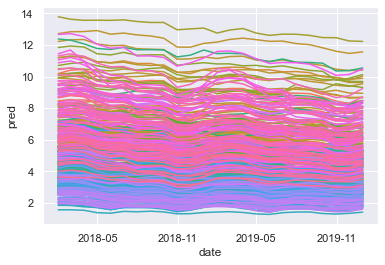

In [89]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

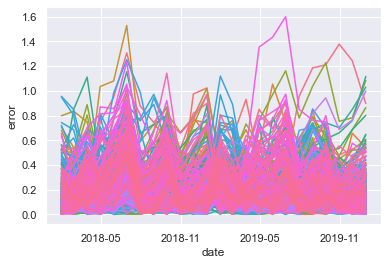

In [90]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

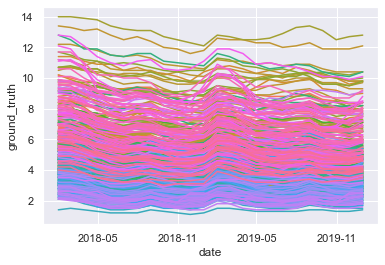

In [91]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

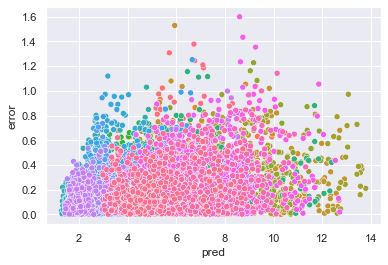

In [92]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [93]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [94]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [95]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

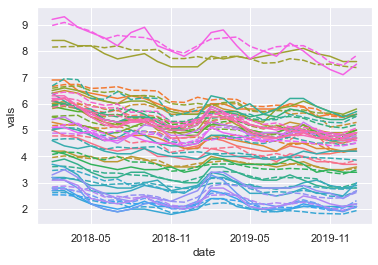

In [96]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into mean errors

In [97]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,7.654453,0.514029
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,8.146062,0.290269
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.730177,0.235069
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.292714,0.222192
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,6.134025,0.393344
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.428801,0.160927
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.451131,0.149345
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.771823,0.176683


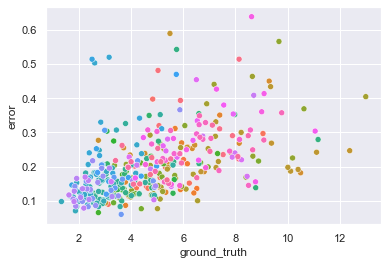

In [98]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

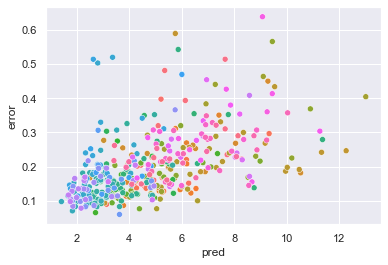

In [99]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [100]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
13073,13,Mecklenburg-Vorpommern,Vorpommern-Rügen,8.616667,9.080248,0.638194
03462,03,Niedersachsen,Wittmund,5.487500,5.750702,0.589225
05914,05,Nordrhein-Westfalen,Hagen,9.666667,9.456875,0.565753
07320,07,Rheinland-Pfalz,Stadt Zweibrücken,5.741667,5.861919,0.542494
09276,09,Freistaat Bayern,Regen,3.154167,3.355386,0.519725
...,...,...,...,...,...,...
05366,05,Nordrhein-Westfalen,Euskirchen,5.008333,5.039858,0.076856
06432,06,Hessen,Darmstadt-Dieburg,4.387500,4.381284,0.076734
09175,09,Freistaat Bayern,Ebersberg,1.862500,1.821620,0.070578


<AxesSubplot:xlabel='error', ylabel='Density'>

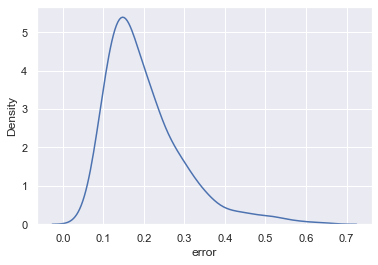

In [101]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [102]:
df.sort_values(by = ['error'], ascending=False)

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
8345,13073,2019-06-30,7.0,8.599673,1.599673,13,Mecklenburg-Vorpommern,Vorpommern-Rügen
1445,03462,2018-06-30,4.4,5.929067,1.529067,03,Niedersachsen,Wittmund
8344,13073,2019-05-31,7.3,8.733983,1.433983,13,Mecklenburg-Vorpommern,Vorpommern-Rügen
21,01001,2019-10-31,8.1,6.721840,1.378160,01,Schleswig-Holstein,"Flensburg, Stadt"
8343,13073,2019-04-30,7.9,9.253987,1.353987,13,Mecklenburg-Vorpommern,Vorpommern-Rügen
...,...,...,...,...,...,...,...,...
4420,08121,2018-05-31,4.9,4.900155,0.000155,08,Baden-Württemberg,Heilbronn
5056,08335,2019-05-31,2.9,2.899908,0.000092,08,Baden-Württemberg,Konstanz
5730,09184,2019-07-31,2.2,2.200044,0.000044,09,Freistaat Bayern,München
3566,07137,2019-03-31,3.4,3.400010,0.000010,07,Rheinland-Pfalz,Mayen-Koblenz


In [103]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

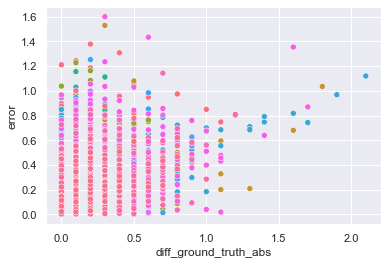

In [104]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

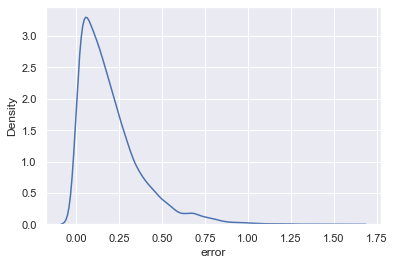

In [105]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

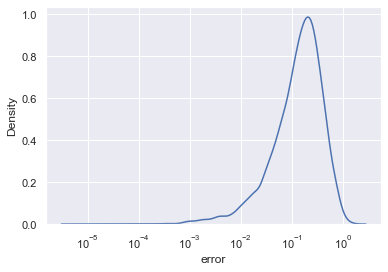

In [106]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [107]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


### Merge to df with mean errors

In [108]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
df_mixed['ags2'] = df_mixed['ags2'].astype('category')
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [109]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    p = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    p.set_title('Residuals')
    plt.savefig(f'{column_name}_resid.png')
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

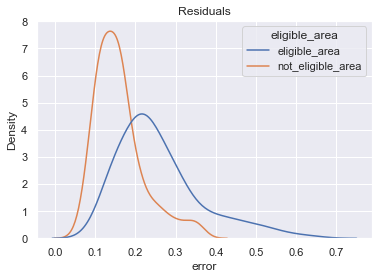

Ttest_indResult(statistic=10.88453967583672, pvalue=6.6404363018331e-23)

In [110]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

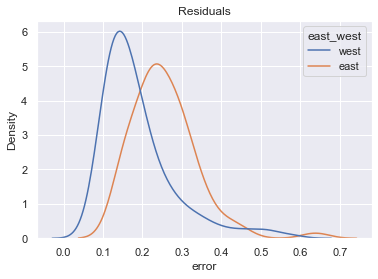

Ttest_indResult(statistic=6.157566993146951, pvalue=8.955862206180588e-09)

In [111]:
compare_error_in_two_groups(df_mixed, 'east_west')

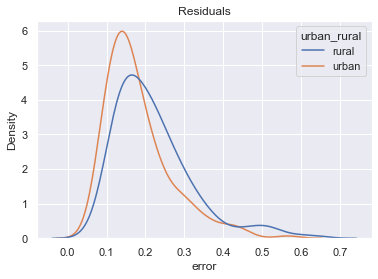

Ttest_indResult(statistic=-4.074555326786926, pvalue=5.585027887494875e-05)

In [112]:
compare_error_in_two_groups(df_mixed, 'urban_rural')

### Compare compare error in multiple groups

In [113]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

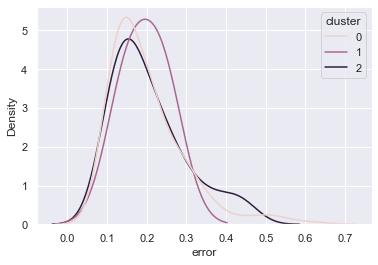

            sum_sq     df         F    PR(>F)
cluster   0.001842    1.0  0.200412  0.654632
Residual  3.667958  399.0       NaN       NaN


In [114]:
compare_error_in_two_groups(df_mixed, "cluster")

In [116]:
#compare_error_in_two_groups(df_mixed, "bundesland")

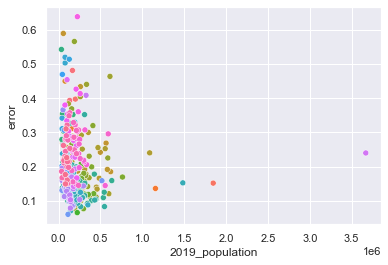

In [117]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

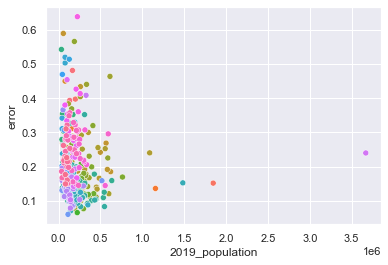

In [118]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [119]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [121]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [122]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [123]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min     1Q  Median     3Q    Max
-0.5827 -0.132 -0.0017 0.1451 0.8126


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -100.220133  4.471851e+03+1.063458e+05j  -0.0000+0.0009j  0.999249
supermarkets_population                             0.003391  1.618300e-02+1.107900e-02j   0.1427-0.0977j  0.862822
supermarkets_average_distance                       0.000030  1.387000e-02+1.603100e-02j   0.0009-0.0011j  0.998859
public_transport_availability                       0.002071  6.137000e-03-2.471000e-03j   0.2903+0.1169j  0.754453
average_distance_bus_stop                           0.000350  1.710000e-04+2.500000e-05j   2.0016-0.2909j  0.043782
average_distance_train_station                      0.000034 -3.700000e-05+5.500000e-05j  -0.2849-0.4215j  0.611235
average_distance_public_transport                  -0.000593  5.470000e-04+2.700000e-05

### Sequential Feature Selector

In [124]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [125]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(150,)","[0.17543331977188426, 0.14102970031853357, 0.2...",0.156636,"(purchasing_power_per_household,)",0.083824,0.065218,0.032609
2,"(150, 195)","[0.19521551714881924, 0.21393580537958257, 0.2...",0.215018,"(purchasing_power_per_household, support_area_...",0.094575,0.073583,0.036791
3,"(33, 150, 195)","[0.22294822684724847, 0.24723029176994615, 0.3...",0.23762,"(activity_index, purchasing_power_per_househol...",0.113355,0.088194,0.044097
4,"(33, 77, 150, 195)","[0.2797618841034343, 0.22297004259335285, 0.29...",0.256074,"(activity_index, number_accomodation_establish...",0.078038,0.060716,0.030358
5,"(33, 77, 119, 150, 195)","[0.32572864596760287, 0.23650686884415995, 0.3...",0.275925,"(activity_index, number_accomodation_establish...",0.091387,0.071102,0.035551
6,"(33, 77, 119, 150, 152, 195)","[0.3114882980130049, 0.2806127074162632, 0.381...",0.294389,"(activity_index, number_accomodation_establish...",0.090648,0.070527,0.035263
7,"(33, 77, 119, 150, 152, 193, 195)","[0.3846631147645747, 0.3121512048764987, 0.375...",0.318909,"(activity_index, number_accomodation_establish...",0.098607,0.07672,0.03836
8,"(33, 77, 119, 150, 152, 187, 193, 195)","[0.39200598176115464, 0.2874271122421247, 0.41...",0.336854,"(activity_index, number_accomodation_establish...",0.110234,0.085766,0.042883
9,"(33, 77, 119, 150, 152, 173, 187, 193, 195)","[0.4213859716373589, 0.31446989669463743, 0.40...",0.349842,"(activity_index, number_accomodation_establish...",0.103135,0.080243,0.040121
10,"(33, 77, 78, 119, 150, 152, 173, 187, 193, 195)","[0.41627110158806857, 0.32567932289890433, 0.4...",0.360842,"(activity_index, number_accomodation_establish...",0.084322,0.065605,0.032803


In [126]:
list(summary_table_select['feature_names'])[:5]

[('purchasing_power_per_household',),
 ('purchasing_power_per_household', 'support_area_status_N'),
 ('activity_index', 'purchasing_power_per_household', 'support_area_status_N'),
 ('activity_index',
  'number_accomodation_establishments',
  'purchasing_power_per_household',
  'support_area_status_N'),
 ('activity_index',
  'number_accomodation_establishments',
  'no_of_public_institution',
  'purchasing_power_per_household',
  'support_area_status_N')]

### Ridge

In [127]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [128]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.5766 -0.1422 -0.0013 0.1469 0.8604


Coefficients:
                                                   Estimate                  Std. Error          t value   p value
_intercept                                       -17.917473  4.584489e+03+1.090245e+05j  -0.0000+0.0002j  0.999869
supermarkets_population                            0.001288 -1.818200e-02-0.000000e+00j  -0.0709+0.0000j  0.943546
supermarkets_average_distance                      0.000034  8.716000e-03+0.000000e+00j   0.0040-0.0000j  0.996848
public_transport_availability                     -0.000332  3.593600e-02+0.000000e+00j  -0.0092+0.0000j  0.992628
average_distance_bus_stop                          0.000396  5.100000e-05+1.120000e-04j   1.3477-2.9307j  0.001360
average_distance_train_station                     0.000022  1.660000e-04-6.300000e-05j   0.1151+0.0438j  0.902081
average_distance_public_transport                 -0.000636  4.470000e-04+4.400000e-05j  -1.

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

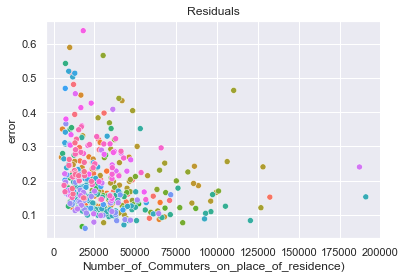

In [135]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.set_title('Residuals')
g.legend_.remove()
plt.savefig('Commuters_Residuals.png')

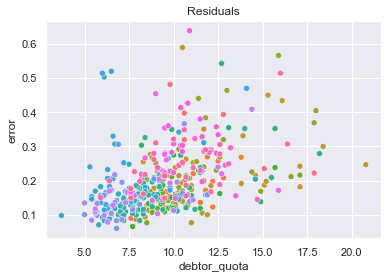

In [130]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('Residuals')
g.legend_.remove()
plt.savefig('debtor_quota_Residuals.png')

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

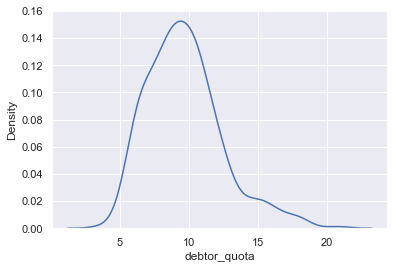

In [131]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

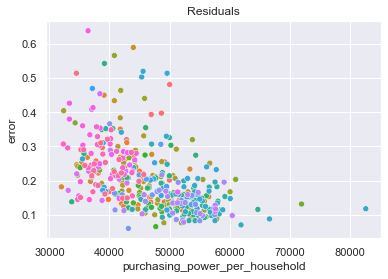

In [132]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('Residuals')
g.legend_.remove()
plt.savefig('purchasing_power_Residuals.png')

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

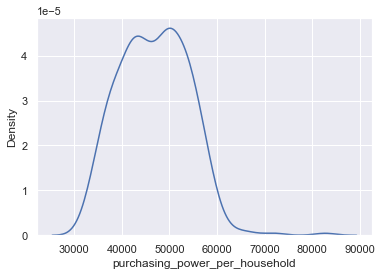

In [133]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

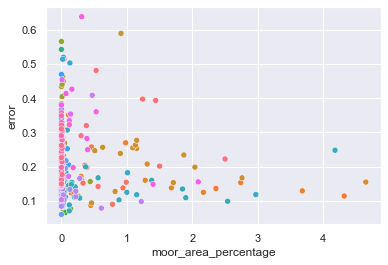

In [134]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()

In [137]:
df['diff_pred'] = df.groupby('ags5')['pred'].diff(1) 

In [139]:
df['diff_sign'] =  np.where(abs(df['diff_pred']) + abs(df['diff_ground_truth']) == abs(df['diff_pred'] + df['diff_ground_truth']), 'same', 'different')

In [141]:
df['diff_sign'].value_counts(normalize=True) * 100

same         72.412718
different    27.587282
Name: diff_sign, dtype: float64